In [1]:
%pylab inline

from collections import defaultdict
from pathlib import Path
import re
import subprocess
import warnings

from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.Alphabet import IUPAC
from hmmlearn.hmm import MultinomialHMM
import pandas as pd
import requests
from scipy.stats import ttest_ind
import seaborn as sns

np.set_printoptions(precision=4)
pd.set_option('display.max_rows', 12)
sns.set(style='ticks', context='talk')

Populating the interactive namespace from numpy and matplotlib


In [2]:
newax = np.newaxis

class HMM(object):
    # create a randomly initialized HMM
    def __init__(self, N, M):
        self.N = N
        self.M = M
        # create random initial state
        self.Π = np.ones(N)/N
        
        # initialize HMM parameters to random positive values
        self.T = np.random.exponential(1, [N, N])
        self.E = np.random.exponential(1, [N, M])
        
        # normalize probability distributions to 1
        self.T /= self.T.sum(axis=1, keepdims=True)
        self.E /= self.E.sum(axis=1, keepdims=True)

    def _predict(self, S):
        s_len = len(S)
        V = np.zeros((self.N, s_len + 1))
        pointer = np.zeros_like(V.T, dtype=int)
        V[0, 0] = 1
        for i in range(1, s_len + 1):
            for l in range(self.N):
                K = V[l, i-1] * self.T[:, l]
                max_k_idx = np.argmax(K)
                V[l, i] = self.E[l, S[i-1]] * K[max_k_idx]
                pointer[i, l] = max_k_idx
        
        max_v_idx = np.argmax(V[:, -1])
        H = np.zeros(s_len, dtype=int)
        H[-1] = max_v_idx
        for i in range(s_len-1, 0, -1):
            H[i-1] = pointer[i, H[i]]
        return H, V.T[1:]
    
    def predict(self, S):
        return self._predict(S)[0]
    
    def predict_proba(self, S):
        return self._predict(S)[1]

    def forward(self, S):
        s_len = len(S)
        F = np.zeros((self.N, s_len + 1))
        F[0, 0] = 1
        for i in range(1, s_len + 1):
            for l in range(self.N):
                F[l, i] = self.E[l, S[i-1]] * (F[:, i-1]*self.T[:, l]).sum()
        
        return F[:, -1].sum()
    
    def alpha_pass(self, S):
        s_len = len(S)
        alpha = np.zeros((s_len, self.N))
        c = np.zeros(s_len)
        alpha[0] = self.Π * self.E[:, S[0]]
        c[0] = alpha[0].sum()
        alpha[0] /= c[0]
        for i in range(1, s_len):
            alpha[i] = self.E[:, S[i]] * (self.T @ alpha[i-1])
            c[i] = alpha[i].sum()
            alpha[i] /= c[i]

        return alpha, c
        
    def beta_pass(self, S, c):
        s_len = len(S)
        beta = np.zeros((s_len, self.N))
        beta[-1] = 1/self.N
        for i in range(s_len - 2, -1, -1):
            beta[i] = (self.T @ (beta[i+1] * self.E[:, S[i+1]]))/c[i+1]

        return beta
    
    def fit(self, S, max_iter=100, tol=1e-4):
        s_len = len(S)
        prev_log_llhood = np.nan
        for i in range(max_iter):
            # E step
            alpha, c = self.alpha_pass(S)
            beta = self.beta_pass(S, c)
            gamma = alpha*beta
            Z = self.E[:, S].T
            xi = (alpha[:-1, :, newax] *
                  self.T[newax, :, :] *
                  beta[1:, newax, :] *
                  Z[1:, newax, :]/c[-1])
            
            # M step
            self.Π = gamma[0]/gamma[0].sum()
            self.T = xi[1:].sum(axis=0)
            self.T /= self.T.sum(axis=1, keepdims=True)
            SS = np.zeros((s_len, self.M))
            SS[np.arange(s_len), S] = 1
            self.E = gamma.T @ SS
            self.E /= self.E.sum(axis=1, keepdims=True)
            
            log_llhood = c.sum()
            difference = np.abs(log_llhood - prev_log_llhood)
            if difference < tol:
                print(f"breaking due to tolerance. i: {i}")
                break
            prev_log_llhood = log_llhood
        if i == max_iter - 1:
            print(f"breaking due to iterations. difference: {difference}")

        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.xi = xi
        self.Z = Z
        return self

# Example 1 - Loaded dice

In [3]:
ld_hmm = MultinomialHMM(n_components=2)
ld_hmm.startprob_ = np.array([0.5, 0.5])
ld_hmm.transmat_ = np.array([[0.9, 0.1],
                             [0.1, 0.9]])
ld_hmm.emissionprob_ = np.array([[1/6]*6,
                                 [0.1]*5 + [0.5]])
s = np.array([int(i) - 1
              for i in '45536531633635551333666266511132141636651666'])
s = s.reshape((len(s), 1))
print(np.exp(ld_hmm.score(s)))
print(np.r_['1,2', ld_hmm.predict_proba(s), s+1,
            ld_hmm.predict(s).reshape((len(s), 1))+1].T[:, :9])

1.82281224879e-33
[[ 0.7952  0.8178  0.8113  0.7736  0.6926  0.7422  0.751   0.7218  0.6453]
 [ 0.2048  0.1822  0.1887  0.2264  0.3074  0.2578  0.249   0.2782  0.3547]
 [ 4.      5.      5.      3.      6.      5.      3.      1.      6.    ]
 [ 1.      1.      1.      1.      1.      1.      1.      1.      1.    ]]


# Example 2 - Lambda phage genome

In [4]:
codebook = {'A': 0, 'C': 1, 'G': 2, 'T': 3}
rev_codebook = {v: k for k, v in codebook.items()}

with open('lambda_phage.txt') as fp:
    s = ''.join([l.strip().upper() for l in fp.readlines()])
    s = np.array([codebook[c] for c in s])
s = s.reshape((len(s), 1))

,prob_CG,prob_AT,symbol_num,symbol,hidden_num,hidden,CG_dens,AT_dens
0,0.134613,0.865387,2,G,1,CG,1.0000,0.0000
1,0.134370,0.865630,2,G,1,CG,1.0000,0.0000
2,0.133989,0.866011,2,G,1,CG,1.0000,0.0000
3,0.133404,0.866596,1,C,1,CG,1.0000,0.0000
4,0.132707,0.867293,2,G,1,CG,1.0000,0.0000
5,0.131651,0.868349,2,G,1,CG,1.0000,0.0000
...,...,...,...,...,...,...,...,...
48496,0.019376,0.980624,2,G,1,CG,0.3985,0.6015
48497,0.019503,0.980497,3,T,1,CG,0.3985,0.6015
48498,0.019704,0.980296,3,T,1,CG,0.3985,0.6015


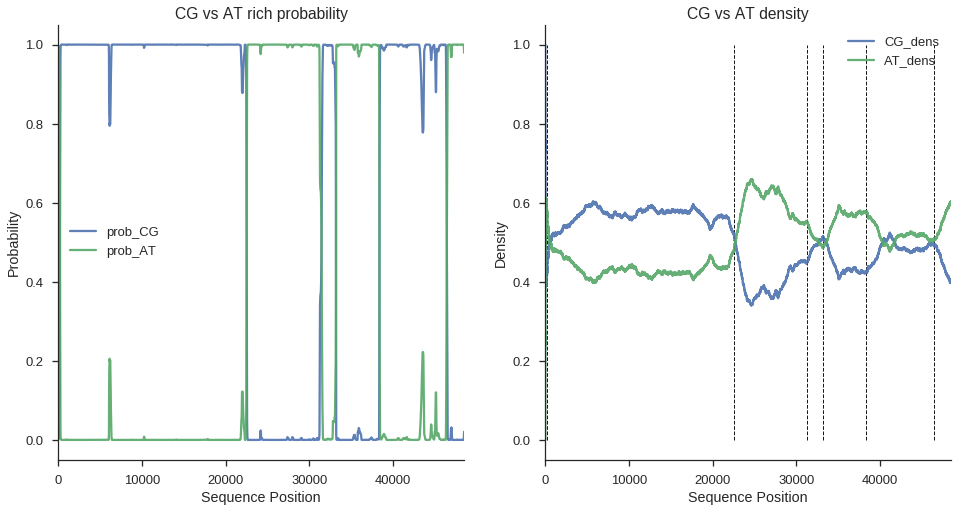

In [5]:
lpg_hmm = MultinomialHMM(n_components=2)
lpg_hmm.startprob_ = np.array([0.5, 0.5])
lpg_hmm.transmat_ = np.array([[0.9998, 0.0002],
                              [0.0002, 0.9998]])
lpg_hmm.emissionprob_ = np.array([[0.2462, 0.2476, 0.2985, 0.2077],
                                  [0.2700, 0.2084, 0.1981, 0.3236]])

lpg_results = pd.DataFrame(lpg_hmm.predict_proba(s),
                           columns=['prob_CG', 'prob_AT'])
lpg_results['symbol_num'] = s
lpg_results['symbol'] =\
    lpg_results.symbol_num.apply(lambda sn: rev_codebook[sn])
lpg_results['hidden_num'] = lpg_hmm.predict(s)
lpg_results['hidden'] = np.where(lpg_results.hidden_num, ['CG'], ['AT'])

lpg_results['CG_dens'] = (
    (lpg_results.symbol == 'C') | (lpg_results.symbol == 'G')
).rolling(2000, min_periods=1).sum()/4000
lpg_results['AT_dens'] = (
    (lpg_results.symbol == 'A') | (lpg_results.symbol == 'T')
).rolling(2000, min_periods=1).sum()/4000
Z = (lpg_results.CG_dens + lpg_results.AT_dens)
lpg_results['CG_dens'] /= Z
lpg_results['AT_dens'] /= Z

cg2at = ((lpg_results[:-1].hidden.values == 'CG') &
         (lpg_results[1:].hidden.values == 'AT'))
at2cg = ((lpg_results[:-1].hidden.values == 'AT') &
         (lpg_results[1:].hidden.values == 'CG'))

_, axes = plt.subplots(1, 2, figsize=(16, 8))
ax1, ax2 = axes.flatten()

lpg_results.plot(y=['prob_CG', 'prob_AT'], alpha=0.9, ax=ax1)
ax1.set_ylabel('Probability')
ax1.set_xlabel('Sequence Position')
ax1.set_title('CG vs AT rich probability')

lpg_results.plot(y=['CG_dens', 'AT_dens'], ax=ax2, alpha=0.9)
ax2.vlines(
    lpg_results.loc[cg2at | at2cg].index, 0, 1, 'k', '--', lw=1, alpha=0.9
)
ax2.set_ylabel('Density')
ax2.set_xlabel('Sequence Position')
ax2.set_title('CG vs AT density')

sns.despine()

lpg_results

# Case study - Odorant receptors

In [6]:
codebook = {'A': 0, 'C': 1, 'G': 2, 'T': 3}
rev_codebook = {v: k for k, v in codebook.items()}

orseqs = list(SeqIO.parse('olfactoryreceptors_demo/347OR.fasta', "fasta",
                          alphabet=IUPAC.protein))
or1 = pd.DataFrame(list(str(orseqs[0].seq)), columns=['aminoacid'])
or1

,aminoacid
0,M
1,P
2,N
3,S
4,T
5,T
...,...
306,F
307,Y
308,S


In [7]:
aa2int_table = pd.read_html(
    'https://de.mathworks.com/help/bioinfo/ref/aa2int.html'
)[2]
aa2int_table['Code'] = aa2int_table.Code.str.upper().str.strip()
aa2int_table['Integer'] = aa2int_table.Integer.astype(int)
aa2int_table.to_csv('aa2int_table.csv', index=False)
code2int = defaultdict(int, **{row.Code: row.Integer
                               for _, row in aa2int_table.iterrows()})

def aa2int(seq):
    return np.array([code2int[c] for c in str(seq)], dtype=int)
aa2int(orseqs[0].seq)

array([13, 15,  3, 16, 17, 17, 20, 13,  7, 14, 11, 11, 13,  2, 14, 16,  4,
       20, 18, 17, 11,  6, 10, 11,  9, 16,  1, 16, 14, 14, 13, 11, 19, 11,
       20, 17, 11, 13,  8,  3, 10, 11, 10, 20, 17, 20, 17, 17,  5,  4, 16,
       16, 11,  9, 13, 15, 13, 19, 14, 14, 11,  2,  3, 11, 16, 10, 11,  4,
        1,  5, 19, 10, 16, 20, 17, 20, 15, 17, 16,  5, 20,  3, 16, 11, 11,
        4, 16, 17, 17, 10, 16, 12,  1,  8,  5, 20,  1,  6, 20, 14, 11, 20,
       20, 14, 14, 20, 19, 20,  7, 11, 11, 14, 11, 17, 10, 13,  1,  9,  4,
        2, 19, 20,  1, 20,  5,  6, 15, 11,  9, 19, 15, 20, 10, 20,  3, 16,
        2, 10,  5, 10,  6, 13, 17, 11,  1, 16, 11, 11, 16,  8, 11, 20, 19,
        1,  8, 13,  9, 17,  8, 16, 17, 14,  6, 11, 15, 14,  5,  2, 16,  3,
       20, 10,  9,  6, 14, 14,  5,  4, 10, 15, 16, 11, 11, 12, 11, 16,  5,
       16,  4, 17, 14, 16,  3,  7, 20, 13, 10, 20, 20, 16,  1, 11,  8, 20,
        8,  8,  8,  5, 14, 10, 14, 10, 10,  2, 16, 19, 10,  9, 10, 14, 16,
       17, 20, 11,  8, 14

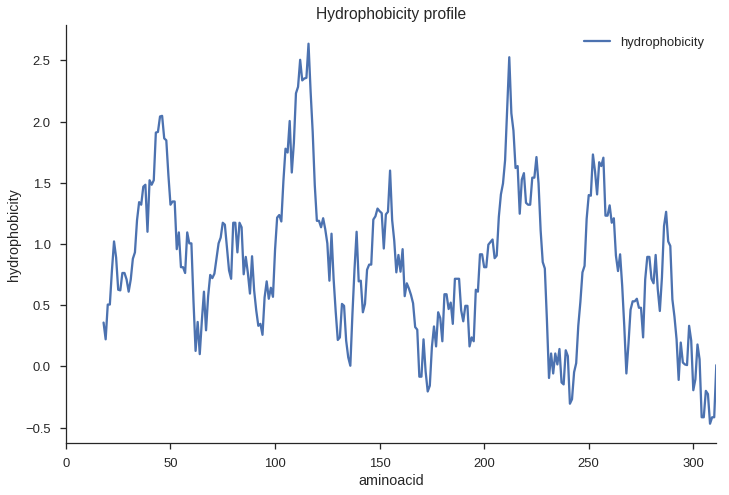

In [8]:
def calc_hydrophobicity(df):
    # Kyte & Doolittle index of hydrophobicity
    kd = { 'A': 1.8,'R':-4.5,'N':-3.5,'D':-3.5,'C': 2.5,
           'Q':-3.5,'E':-3.5,'G':-0.4,'H':-3.2,'I': 4.5,
           'L': 3.8,'K':-3.9,'M': 1.9,'F': 2.8,'P':-1.6,
           'S':-0.8,'T':-0.7,'W':-0.9,'Y':-1.3,'V': 4.2 }
    df = df.copy()
    df['hydrophobicity'] = [kd[residue] for residue in df.aminoacid]
    df['hydrophobicity_smooth'] = df.hydrophobicity.rolling(19).mean()
    return df


def hydroplot(df, ax=None):
    ax1 = df.plot(y='hydrophobicity_smooth', label='hydrophobicity', ax=ax)
    ax1.set_ylabel('hydrophobicity')
    ax1.set_xlabel('aminoacid')
    ax1.set_title('Hydrophobicity profile')
    if ax is None:
        sns.despine()
        plt.tight_layout()
    return ax1
    
or1 = calc_hydrophobicity(or1)
hydroplot(or1);

In [9]:
nr_seqs = 20
intseqs = [aa2int(orseq.seq).reshape((len(orseq.seq), 1))-1
           for orseq in orseqs[:nr_seqs]]

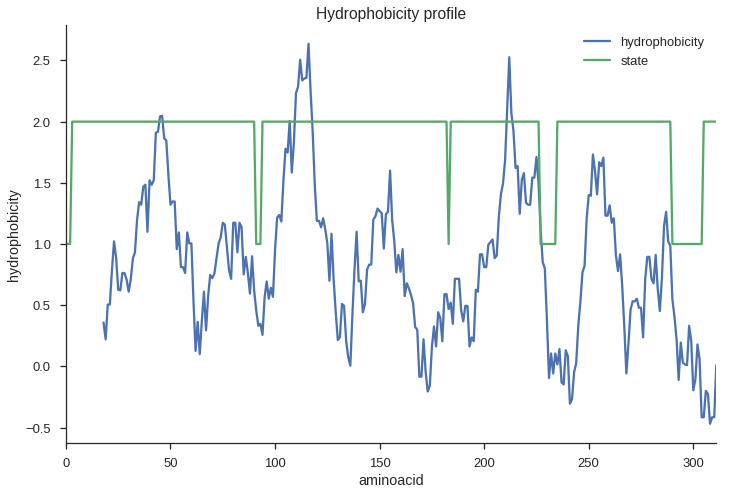

In [10]:
or_hmm = MultinomialHMM(n_components=2, startprob_prior=0.5)
or_hmm.startprob_ = np.array([0.5, 0.5])
or_hmm.transmat_ = np.array([[0.7338, 0.2662],
                             [0.0711, 0.9289]])
or_hmm.emissionprob_ = np.array([[0.0820, 0.0971, 0.0657, 0.0408, 0.0000, 
                                  0.0429, 0.0553, 0.0555, 0.0187, 0.0242,
                                  0.0715, 0.1480, 0.0874, 0.0000, 0.0366,
                                  0.0818, 0.0228, 0.0045, 0.0000, 0.0653],    
                                 [0.0626, 0.0181, 0.0188, 0.0248, 0.0464,
                                  0.0153, 0.0122, 0.0416, 0.0306, 0.0902,
                                  0.1542, 0.0000, 0.0424, 0.0857, 0.0427,
                                  0.0911, 0.0763, 0.0072, 0.0583, 0.0814]])

ax = hydroplot(or1)
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    ax.plot(or_hmm.predict(intseqs[0]) + 1, label='state')
ax.legend()

## HMMLearn-based

In [11]:
def load_hmmer_model(hmmer_model_def):
    lines = [l.strip() for l in hmmer_model_def.splitlines() if l.strip()]
    i = 0
    last_header_line = np.inf
    match_emissions = []
    insert_emissions = []
    state_transitions = []
    prob_pattern = re.compile(r'\.\d+|\d+\.\d+|\*')
    while i < len(lines):
        line = lines[i]
        if line.startswith('LENG'):
            node_groups_nr = int(re.match(r'LENG\s+(\d+)',
                                          line).group(1)) + 1
        elif line.startswith('HMM '):
            symbols = [n.strip() for n in re.findall(r'\s\w\s?', line)]
            i += 1
            hidden_names = re.findall(r'\w->\w', lines[i])
            last_header_line = i
        elif line.startswith('COMPO'):
            last_header_line = i
        elif line.startswith('//'):
            break
        elif last_header_line + 1 == i:
            match_emissions.append(['*']*len(symbols))
            insert_emission = prob_pattern.findall(line)
            assert len(insert_emission) == len(symbols)
            insert_emissions.append(insert_emission)

            i +=1
            st_trans = prob_pattern.findall(lines[i])
            assert len(st_trans) == 7
            state_transitions.append(st_trans)
        elif last_header_line < i:
            try:
                match_emission = prob_pattern.findall(line)
                assert len(match_emission) == len(symbols)
                match_emissions.append(match_emission)

                i += 1
                insert_emission = prob_pattern.findall(lines[i])
                assert len(insert_emission) == len(symbols)
                insert_emissions.append(insert_emission)

                i += 1
                st_trans = prob_pattern.findall(lines[i])
                assert len(st_trans) == 7
                state_transitions.append(st_trans)
            except AssertionError as e:
                print(f'i: {i}')
                print(f'symbols: {symbols}')
                print(f'len(symbols): {len(symbols)}')
                print(f'match_emission: {len(match_emission)}, '
                      f'{match_emission}')
                print(f'insert_emission: {len(insert_emission)}, '
                      f'{insert_emission}')
                print(f'st_trans: {len(st_trans)}, {st_trans}')
                raise
        i += 1
    assert len(state_transitions) == node_groups_nr
    hidden_nodes_nr = node_groups_nr*3
    T = np.zeros((hidden_nodes_nr + 1, hidden_nodes_nr + 1))
    for j, i in enumerate(range(0, hidden_nodes_nr, 3)):
        state_transition = [np.exp(-float(p)) if p != '*' else 0
                            for p in state_transitions[j]]
        # ### Match transitions ###
        # M_k -> M_{k+1}
        T[i, i+3] = state_transition[0]
        # M_k -> I_k
        T[i, i+1] = state_transition[1]
        if i < hidden_nodes_nr-3:
            # M_k -> D_{k+1}
            T[i, i+5] = state_transition[2]
        # Insert transitions
        # I_k -> M_{k+1}
        T[i+1, i+3] = state_transition[3]
        # I_k -> I_k
        T[i+1, i+1] = state_transition[4]
        # Delete transitions
        # D_k -> M_{k+1}
        T[i+2, i+3] = state_transition[5]
        if i < hidden_nodes_nr-3:
            # D_k -> D_{k+1}
            T[i+2, i+5] = state_transition[6]
    T[-1, -1] = 1
    E = np.zeros((hidden_nodes_nr+1, len(symbols)))
    for j, i in enumerate(range(0, hidden_nodes_nr, 3)):
        # Match emissions
        try:
            match_emission = [np.exp(-float(p)) if p != '*' else 0
                              for p in match_emissions[j]]
        except:
            print(len(match_emissions), j)
            raise
        E[i] = match_emission
        # Insert emissions
        insert_emision = [np.exp(-float(p)) if p != '*' else 0
                          for p in insert_emissions[j]]
        E[i+1] = insert_emision
    model = MultinomialHMM(hidden_nodes_nr + 1)
    model.startprob_ = np.array([1/(hidden_nodes_nr+1)]*(hidden_nodes_nr+1))
    model.transmat_ = T
    model.emissionprob_ = E
    return model

In [12]:
def hmm_align_score(seq, hmm_def=None, hmm_model=None):
    assert hmm_def or hmm_model
    if not hmm_model:
        hmm_model = load_hmmer_model(hmm_def)
    seq = np.atleast_2d(seq)
    score, hidden_pred = hmm_model.decode(seq)
    pos_score, _ = hmm_model.score_samples(seq)
    return hidden_pred, score, pos_score

In [13]:
nr_seqs = len(intseqs)
scores = np.zeros((nr_seqs, 4))
hidden_seqs = []
shuffled_seqs = [seq.copy() for seq in intseqs]
[np.random.shuffle(seq) for seq in shuffled_seqs]
response = requests.get(f'http://pfam.xfam.org/family/PF00001/hmm')
hmm7tm = load_hmmer_model(response.text)
for i, (seq, shuffled_seq) in enumerate(zip(intseqs, shuffled_seqs)):
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        pred_seq, scores[i, 0], scores[i, 1] =\
            hmm_align_score(seq, hmm_model=hmm7tm)
        pred_sseq, scores[i, 2], scores[i, 3] =\
            hmm_align_score(shuffled_seq, hmm_model=hmm7tm)
        hidden_seqs.append((pred_seq, pred_sseq))
print(np.array_repr(scores, suppress_small=True))

array([[ -996.1301,  -988.8508,  -997.1526,  -991.5237],
       [ -929.2308,  -927.8235,  -937.2233,  -933.6334],
       [-1028.106 , -1017.4374, -1024.9415, -1017.3   ],
       [-1006.5108, -1000.6685, -1002.7682,  -997.3802],
       [ -982.9905,  -977.458 ,  -983.0518,  -976.3089],
       [-1011.1321, -1007.325 , -1015.0184, -1010.9356],
       [-1000.7659,  -997.5492, -1000.891 ,  -995.012 ],
       [ -996.1174,  -992.299 ,  -997.2819,  -994.0038],
       [-1010.6741, -1004.5841, -1001.9783,  -996.1978],
       [-1037.6106, -1028.911 , -1038.6436, -1032.3922],
       [-1045.842 , -1038.8478, -1041.6233, -1037.3721],
       [-1033.9982, -1028.6949, -1030.8073, -1025.3659],
       [-1003.2696, -1001.3518, -1009.6279, -1005.6465],
       [-1034.7344, -1027.4441, -1034.784 , -1031.0566],
       [-1026.8555, -1021.4288, -1019.766 , -1018.0442],
       [-1037.409 , -1030.3676, -1035.5815, -1028.4339],
       [-1026.3921, -1016.5037, -1028.0832, -1023.4339],
       [-1091.963 , -1083.766 ,

## HMMER-based

In [14]:
def build_hmmer(pfam_id):
    url = f'http://pfam.xfam.org/family/{pfam_id}/alignment/seed'
    seed_alignment = requests.get(url).text
    hmm_name = Path(f'{pfam_id}.hmm')
    p = subprocess.Popen(['hmmbuild', '--informat', 'Stockholm',
                          str(hmm_name), '-'],
                         stdin=subprocess.PIPE,
                         stdout=subprocess.PIPE,
                         stderr=subprocess.STDOUT)
    output = p.communicate(input=bytes(seed_alignment, encoding='ascii'))[0]
    return hmm_name


def hmmer_align_score(hmm_name, seq):
    p = subprocess.Popen(['hmmsearch', '-Z', '1', '--max', str(hmm_name), '-'],
                         stdin=subprocess.PIPE,
                         stdout=subprocess.PIPE,
                         stderr=subprocess.STDOUT)
    result = p.communicate(input=bytes(seq, encoding='ascii'))[0]
    
# Scores for complete sequences (score includes all domains):
#    --- full sequence ---   --- best 1 domain ---    -#dom-
#     E-value  score  bias    E-value  score  bias    exp  N  Sequence   Description
#     ------- ------ -----    ------- ------ -----   ---- --  --------   -----------
#     1.3e-24   72.9  21.9      3e-24   71.7  21.9    1.7  1  OR01.01.01  

    lines = [line.strip().decode() for line in result.splitlines()]
    lines = [line for line in lines
             if (line and
                 not line.startswith('#') and
                 not line.startswith('--'))]
    score_pattern = re.compile(r'-?\d+\.\d+e-?\d+|-?\d+\.\d+|-?\d+')
    for i, line in enumerate(lines):
        line = line.strip()
        if line.startswith('E-value  score  bias'):
            line = lines[i+1]
            stats = score_pattern.findall(line)
            if len(stats) < 2:
                score = -np.inf
            else:
                score = float(stats[1])
            break
    return score


def hmmer_alignment(hmm_name, seq):
    p = subprocess.Popen(['hmmalign', '--outformat', 'A2M',
                          str(hmm_name), '-'],
                         stdin=subprocess.PIPE,
                         stdout=subprocess.PIPE,
                         stderr=subprocess.STDOUT)
    result = p.communicate(input=bytes(seq, encoding='ascii'))[0]
    
# >OR11.35.01
# aalvmtlkieskvirsalfsinssamsrtmyinmhyisdrglifkffhilfaiklrgmcl
# cglfldnfldvasdlndfnfqpieitfltyylstyvmdpfklaqllsfflpkvvvefnvy
# vmksyvvtasisvdvksifiyhiylfcimv------------------------------
# ------------------------------------------------------------
# ------------------------------------------------------------
# -----P------------------------------------------------------
# ----------------------------------------------------------vs
# illlgcpailiscvalgfkrtlycaggrtvlatifsnhtylpgftnafrdmyvamsnqst
# invkttktgkpyynvylkviifelqtyyynesvvilltkdhlnsltpglvdadvcslllt
# shfagvissmlfgpfyktfrahcpiisfsflnkeinmalyslivglvhmqyvdrvgmtl

    lines = [line.strip().decode() for line in result.splitlines()]
    lines =[line for line in lines
            if line and not line.startswith('>')]

    return ''.join(lines)

In [15]:
hmmer_alignment('PF00001.hmm', orseqs[0].format('fasta'))

'mpnsttvmefllmrfsdvwtlqilhsasffmlylvtlmGNILIVTVTTCDSSLHMPMYFFLRNLSILDACYISVTVPTSCVNSLLDSTTISKAGCVAQVFLVVFFVYVELLFLTIMAHDRYVAVCQPLHYPVIVNSRICIqMTLASLLSGLVYAGMHTGSTFqlpfcrsnvihqffCDIPSLLKLSCSDTF-SNEVMIVVSALGVGGGCFIFIIRSYIHIFSTVLGFP---------------------------------------------------------------------------------------------rgadrtkafstciphilvvsvflsscssvylrppaipaatqdlilsgfysimpplfnpiiyslrnkqikvaikkimkrifysenv'

In [16]:
nr_seqs = len(orseqs)
stats = []
shuffled_seqs = [SeqRecord(Seq(''.join(np.random.choice(list(str(rec.seq)),
                                                        len(str(rec.seq)),
                                                        replace=False)),
                               IUPAC.IUPACProtein()),
                               id=rec.id, name=rec.name,
                               description=rec.description)
                 for rec in orseqs]

hmm7tm_name = build_hmmer('PF00001')
for i, (rec, shuf_rec) in enumerate(zip(orseqs, shuffled_seqs)):
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        orig_score = hmmer_align_score(hmm7tm_name, rec.format('fasta'))
        shuf_score = hmmer_align_score(hmm7tm_name, shuf_rec.format('fasta'))
        orig_aling = hmmer_alignment(hmm7tm_name, rec.format('fasta'))
        shuf_aling = hmmer_alignment(hmm7tm_name, shuf_rec.format('fasta'))
        stats.append((rec.id, orig_score, shuf_score,
                      orig_aling, shuf_aling))
stats = pd.DataFrame(stats, columns=['Seq_id', 'Original Score',
                                     'Shuffled Score', 'OA', 'SA'])
stats

,Seq_id,Original Score,Shuffled Score,OA,SA
0,OR01.01.01,72.9,-10.7,mpnsttvmefllmrfsdvwtlqilhsasffmlylvtlmGNILIVTV...,adaswrltshffsdmslvmlilrsaiqikitpaillcieivfcccn...
1,OR01.01.02,73.2,-11.7,mgfsnswdiqivhaalfflvylaaviGNLLIIILTTLDVHLQTPMY...,vyspqdrfitmrtaarsfpccvlsnlthftsfesasckmyvrssyi...
2,OR01.01.03,69.1,-9.6,mtnqtqmmefllvrftenwvllrlhallfsliyltavlm-NLVIIL...,aihiyveivlntaiysillseflllmiavnssiavsdqlatilcss...
3,OR01.01.04,79.6,-3.0,manvtlvtgfllmgfsniqklrilygvlflliylaalms-NLLIIT...,vvlllkvtclscsakspecyifsnlpvintfmiplvsglangetvt...
4,OR01.01.05,-28.0,-5.9,manltivtefilmgfstnknmcilhsilflliylcalmGNVLIIMI...,vfhlkilvlmvilipasvipnllgkhsalhvtillsflssalatln...
5,OR01.02.01,83.0,-8.2,menynqtstdfillglfppsiidlfffilivfiflmaliGNLSMIL...,fihlmdvayrslynihvvyfmciccvdaldmvsllfimalgslplr...
...,...,...,...,...,...
341,OR19.05.03,-23.0,-9.1,mlglnhtsmsefilvgfsafphlqlmlfllfllmylftllGNLLIM...,avstysrnyipgtglignvlcspqlaklrlylfmlsffhhalplki...
342,OR19.05.04,63.2,-18.7,mpgqnyrtisefilsgfsafpqqllpvlfllyllmflftllGNLLI...,yavmkcsgnfsslagpvfsfttlsfgsdllesiscfgrpnlsftmc...
343,OR19.05.05,72.9,-7.1,mpsqnysiisefnlfgfsafpqhllpilfllyllmflftllGNLLI...,annvfcqmvmeitclnlafmfplvpdystisyiialpsavnimmsn...


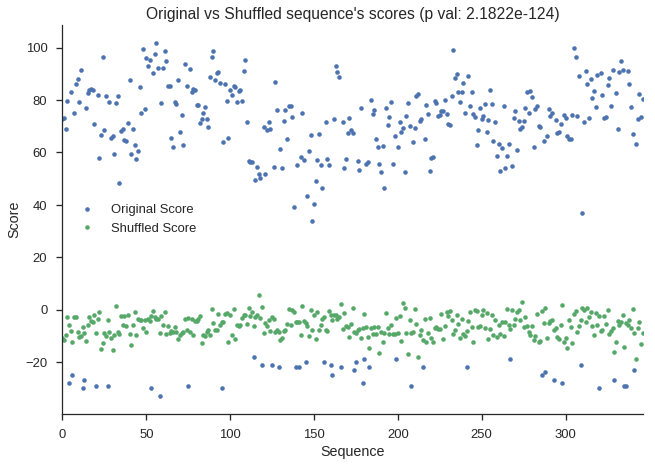

In [17]:
scores = stats.loc[:, ['Original Score', 'Shuffled Score']].astype(float)
scores = scores.rename(columns={'Original Score': 'orig_score',
                                'Shuffled Score': 'shuf_score'})
scores = scores.where(scores > -1e6, np.nan)
scores = scores.where(scores < 1e6, np.nan)
statistic, p = ttest_ind(scores.orig_score, scores.shuf_score,
                         equal_var=False, nan_policy='omit')

ax = stats.plot(y=['Original Score', 'Shuffled Score'],
                marker='.', ls='None',
                title=f"Original vs Shuffled sequence's scores "
                      f"(p val: {p:.4e})")
ax.set_xlabel('Sequence')
ax.set_ylabel('Score')
sns.despine()

In [18]:
indexes = np.random.choice(stats.index, 10, replace=False)

stats.assign()
with pd.option_context('display.width', 130, 'display.max_colwidth', 100,
                       'display.max_rows', 20):
    print(stats.loc[indexes, ['Seq_id', 'OA', 'SA']]
               .melt('Seq_id', value_vars=['OA', 'SA'], var_name='T',
                     value_name='Alignment')
               .sort_values('Seq_id'))

        Seq_id   T                                                                                            Alignment
8   OR01.01.05  OA  manltivtefilmgfstnknmcilhsilflliylcalmGNVLIIMITTLDHHLHTPVYFFLKNLSFLDLCLISVTAPKSIANSLIHNNSISFLGCV...
18  OR01.01.05  SA  vfhlkilvlmvilipasvipnllgkhsalhvtillsflssalatlnfsvmctlglllrnpvcaasialtgslsqvtsyikdgaihlfisfaadi--...
4   OR01.06.02  OA  mvrhtnesnlagfillgfsdypqlqkvlfvlililylltilGNTTIILVSRLEPKLHMPMYFFLSHLSFLYRCFTSSVIPQLLVNLWepMKTIAYG...
14  OR01.06.02  SA  fgflnilpvamlivlgitcrqrhnsvammrkftpdlavflaigilkfdesslhlhraselvlkktpqmislvilsllthgrlwnttateaqmlyvs...
5   OR01.12.02  OA  mttiilevdnhtvttrfillgfptrpafqllffsiflatylltllENLLIILAIHSDGQLHKPMYFFLSHLSFLEMWYVTVISPKMLVDFLSHDKS...
15  OR01.12.02  SA  yfnvsllepshltaafgvyavyrnrhdlikslliatlftffnlmvvhmsaflvltalrmsismiptmrqnicslgsffrihmivgfpgslntrafa...
1   OR06.08.01  OA  merknqtaitefiilgfsnlnelqfllftiffltyfctlgGNILIILTTVTDPHLHTPMYYFLGNLAFIDICYTTSNVPQMMVHLLSKKKSISYVG...
11  OR06.08.01  SA  dkncilyfrsdsinraiiay